In [1]:
# 🧹 Preprocessing EEG Dataset - Notebook 02
# Focus: Sélection de features + Gestion du déséquilibre
# Priorité: Interprétabilité & Précision maximale

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif, chi2, mutual_info_classif
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

In [4]:
print("🧹 PREPROCESSING POUR DÉTECTION D'ÉPILEPSIE")
print("Objectif: Préparer les données pour modèles interprétables")
print("="*70)

🧹 PREPROCESSING POUR DÉTECTION D'ÉPILEPSIE
Objectif: Préparer les données pour modèles interprétables


In [5]:
# =============================================================================
# 1️⃣ CHARGEMENT ET PRÉPARATION INITIALE
# =============================================================================

In [7]:
print("📂 Chargement du dataset...")
df = pd.read_csv('C:\epilepsy-detection-project-main\Data\Raw\EEG_Scaled_data.csv')

📂 Chargement du dataset...


In [8]:
# Identifier la colonne cible
possible_targets = ['y', 'target', 'label', 'class', 'seizure']
target_col = None
for col in possible_targets:
    if col in df.columns:
        target_col = col
        break
if target_col is None:
    target_col = df.columns[-1]

In [9]:
print(f"✅ Dataset: {df.shape}")
print(f"✅ Colonne cible: {target_col}")

✅ Dataset: (11233, 36865)
✅ Colonne cible: target


In [10]:
# Préparation X, y
X = df.drop(columns=[target_col])
y = df[target_col]

In [11]:
# Mapping des labels si nécessaire
if set(y.unique()) == {1, 2}:
    y = (y == 2).astype(int)  # 1->0 (non-épileptique), 2->1 (épileptique)
elif set(y.unique()) == {4, 5}:  # Cas fréquent dans certains datasets
    y = (y == 5).astype(int)


In [12]:
print(f"✅ Features: {X.shape[1]:,}")
print(f"✅ Distribution: {Counter(y)}")

✅ Features: 36,864
✅ Distribution: Counter({0: 9799, 1: 1434})


In [13]:
# =============================================================================
# 2️⃣ FEATURE SELECTION - MÉTHODES MULTIPLES
# =============================================================================

In [14]:
print("\n" + "="*70)
print("🔬 SÉLECTION DE FEATURES (Interprétabilité)")
print("="*70)


🔬 SÉLECTION DE FEATURES (Interprétabilité)


In [18]:
import numpy as np
from sklearn.feature_selection import SelectKBest, f_classif

print("\n1️⃣ Sélection univariée (F-statistique)...")

# 1️⃣ Downcast to float32 column by column to save memory
for col in X.columns:
    X[col] = X[col].astype(np.float32)

# 2️⃣ Compute variance manually to avoid huge dense array
variances = X.var(axis=0)
non_constant_cols = variances[variances > 0].index  # keep only columns with variance > 0
X_reduced = X[non_constant_cols]

# 3️⃣ Sample rows if too large for memory
max_rows = 1000  # adjust based on available memory
if X_reduced.shape[0] > max_rows:
    sample_idx = np.random.choice(X_reduced.shape[0], size=max_rows, replace=False)
    X_sample = X_reduced.iloc[sample_idx]
    y_sample = y.iloc[sample_idx] if hasattr(y, "iloc") else y[sample_idx]
else:
    X_sample, y_sample = X_reduced, y

# 4️⃣ Select top k features
k_best = min(5000, X_reduced.shape[1])
selector_f = SelectKBest(score_func=f_classif, k=k_best)
selector_f.fit(X_sample, y_sample)

# 5️⃣ Transform full dataset using selected features
X_f = selector_f.transform(X_reduced)
selected_features_f = X_reduced.columns[selector_f.get_support()]

print(f"✅ {len(selected_features_f)} meilleures features sélectionnées sur {X.shape[1]} initiales.")


1️⃣ Sélection univariée (F-statistique)...
✅ 5000 meilleures features sélectionnées sur 36864 initiales.


In [19]:
print(f"   ✅ Features sélectionnées: {len(selected_features_f):,}")
print(f"   ✅ Scores moyens: {selector_f.scores_.mean():.2f}")

   ✅ Features sélectionnées: 5,000
   ✅ Scores moyens: 3.81


In [21]:
# 2.2 MÉTHODE 2: Information Mutuelle
import numpy as np
import pandas as pd
from sklearn.feature_selection import mutual_info_classif

print("\n2️⃣ Sélection par information mutuelle (optimisée pour mémoire)...")

# 1️⃣ Downcast pour économiser la mémoire
for col in X.columns:
    X[col] = X[col].astype(np.float32)

# 2️⃣ Paramètres
k_mi = min(3000, X.shape[1])
batch_size = 500  # nombre de colonnes à traiter par lot (ajuster si besoin)

# 3️⃣ Calcul batch par batch
scores = []
cols = list(X.columns)

for start in range(0, len(cols), batch_size):
    end = min(start + batch_size, len(cols))
    X_batch = X[cols[start:end]]
    # mutual_info_classif renvoie un score par feature
    mi_scores = mutual_info_classif(X_batch, y, discrete_features='auto', random_state=0)
    scores.extend(mi_scores)
    print(f"✅ Batch {start}-{end} traité")

# 4️⃣ Recombiner les scores
scores = np.array(scores)
mi_df = pd.DataFrame({'feature': cols, 'score': scores})

# 5️⃣ Sélectionner les top k_mi features
mi_df_sorted = mi_df.sort_values(by="score", ascending=False)
top_features = mi_df_sorted.head(k_mi)["feature"].tolist()

# 6️⃣ Construire le nouveau X_mi
X_mi = X[top_features]

print(f"✅ {len(top_features)} meilleures features sélectionnées sur {X.shape[1]} initiales.")


2️⃣ Sélection par information mutuelle (optimisée pour mémoire)...
✅ Batch 0-500 traité
✅ Batch 500-1000 traité
✅ Batch 1000-1500 traité
✅ Batch 1500-2000 traité
✅ Batch 2000-2500 traité
✅ Batch 2500-3000 traité
✅ Batch 3000-3500 traité
✅ Batch 3500-4000 traité
✅ Batch 4000-4500 traité
✅ Batch 4500-5000 traité
✅ Batch 5000-5500 traité
✅ Batch 5500-6000 traité
✅ Batch 6000-6500 traité
✅ Batch 6500-7000 traité
✅ Batch 7000-7500 traité
✅ Batch 7500-8000 traité
✅ Batch 8000-8500 traité
✅ Batch 8500-9000 traité
✅ Batch 9000-9500 traité
✅ Batch 9500-10000 traité
✅ Batch 10000-10500 traité
✅ Batch 10500-11000 traité
✅ Batch 11000-11500 traité
✅ Batch 11500-12000 traité
✅ Batch 12000-12500 traité
✅ Batch 12500-13000 traité
✅ Batch 13000-13500 traité
✅ Batch 13500-14000 traité
✅ Batch 14000-14500 traité
✅ Batch 14500-15000 traité
✅ Batch 15000-15500 traité
✅ Batch 15500-16000 traité
✅ Batch 16000-16500 traité
✅ Batch 16500-17000 traité
✅ Batch 17000-17500 traité
✅ Batch 17500-18000 traité
✅ Ba

In [23]:
# 2.3 MÉTHODE 3: Random Forest Feature Importance
print("\n3️⃣ Sélection par Random Forest importance...")
rf_selector = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_selector.fit(X, y)


3️⃣ Sélection par Random Forest importance...


,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [24]:
# Sélectionner top features par importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_selector.feature_importances_
}).sort_values('importance', ascending=False)

In [25]:
top_k_rf = min(2000, X.shape[1])  # Top 2000 features
selected_features_rf = feature_importance.head(top_k_rf)['feature'].values

In [26]:
print(f"   ✅ Features sélectionnées: {len(selected_features_rf):,}")
print(f"   ✅ Importance max: {feature_importance['importance'].max():.6f}")

   ✅ Features sélectionnées: 2,000
   ✅ Importance max: 0.002651


In [28]:
# 2.4 INTERSECTION DES MÉTHODES (Features robustes)
print("\n4️⃣ Intersection des méthodes...")
set_f = set(selected_features_f)
set_mi = set(top_features)  
set_rf = set(selected_features_rf)


4️⃣ Intersection des méthodes...


In [29]:
intersection_all = set_f & set_mi & set_rf
intersection_2 = (set_f & set_mi) | (set_f & set_rf) | (set_mi & set_rf)

In [30]:
print(f"   🎯 Intersection 3 méthodes: {len(intersection_all):,} features")
print(f"   🎯 Intersection 2/3 méthodes: {len(intersection_2):,} features")

   🎯 Intersection 3 méthodes: 89 features
   🎯 Intersection 2/3 méthodes: 1,144 features


In [31]:
# Choisir la stratégie finale
if len(intersection_2) >= 500:  # Assez de features robustes
    final_features = list(intersection_2)
    strategy = "Intersection 2/3 méthodes"
elif len(selected_features_rf) >= 1000:
    final_features = list(selected_features_rf[:1000])
    strategy = "Top 1000 RF importance"
else:
    final_features = list(selected_features_f[:1000])
    strategy = "Top 1000 F-statistique"

In [32]:
print(f"\n✅ STRATÉGIE FINALE: {strategy}")
print(f"✅ FEATURES FINALES: {len(final_features):,}")


✅ STRATÉGIE FINALE: Intersection 2/3 méthodes
✅ FEATURES FINALES: 1,144


In [33]:
# Créer le dataset final
X_selected = X[final_features]

In [34]:
# =============================================================================
# 3️⃣ ANALYSE DES FEATURES SÉLECTIONNÉES
# =============================================================================

In [35]:
print("\n" + "="*70)
print("📊 ANALYSE DES FEATURES SÉLECTIONNÉES")
print("="*70)


📊 ANALYSE DES FEATURES SÉLECTIONNÉES


In [36]:
# Visualisation de l'importance des top features
plt.figure(figsize=(15, 6))

<Figure size 1500x600 with 0 Axes>

<Figure size 1500x600 with 0 Axes>

<Axes: >

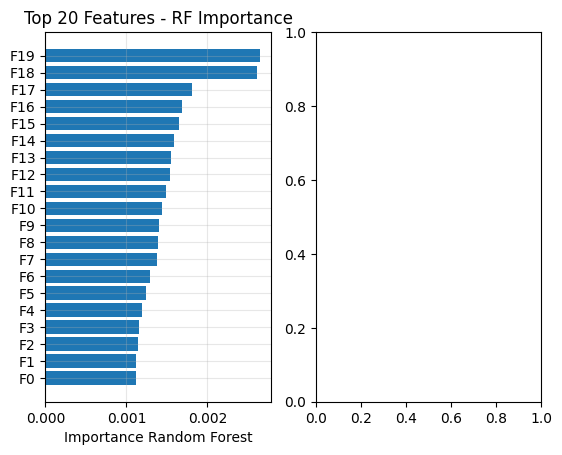

In [66]:
plt.subplot(1, 2, 1)
top_20_rf = feature_importance.head(20)
plt.barh(range(20), top_20_rf['importance'].values[::-1])
plt.yticks(range(20), [f"F{i}" for i in range(20)])  # Anonymiser pour lisibilité
plt.xlabel('Importance Random Forest')
plt.title('Top 20 Features - RF Importance')
plt.grid(True, alpha=0.3)
plt.subplot(1, 2, 2)

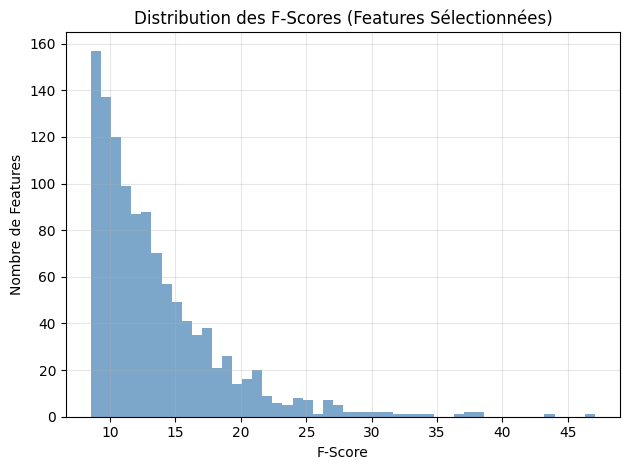

In [65]:
# Distribution des scores de sélection
scores_selected = selector_f.scores_[selector_f.get_support()][:len(final_features)]
plt.hist(scores_selected, bins=50, alpha=0.7, color='steelblue')
plt.xlabel('F-Score')
plt.ylabel('Nombre de Features')
plt.title('Distribution des F-Scores (Features Sélectionnées)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [40]:
plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

In [41]:
# =============================================================================
# 4️⃣ GESTION DU DÉSÉQUILIBRE DES CLASSES
# =============================================================================

In [42]:
print("\n" + "="*70)
print("⚖️ GESTION DU DÉSÉQUILIBRE DES CLASSES")
print("="*70)


⚖️ GESTION DU DÉSÉQUILIBRE DES CLASSES


In [43]:
print(f"Distribution originale: {Counter(y)}")
ratio_original = Counter(y)[0] / Counter(y)[1]
print(f"Ratio déséquilibre: 1:{ratio_original:.1f}")

Distribution originale: Counter({0: 9799, 1: 1434})
Ratio déséquilibre: 1:6.8


In [44]:
# Split stratifié AVANT rééquilibrage
X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

In [45]:
print(f"\n✅ Split stratifié:")
print(f"   Train: {X_train.shape[0]:,} échantillons")
print(f"   Test: {X_test.shape[0]:,} échantillons")
print(f"   Distribution train: {Counter(y_train)}")
print(f"   Distribution test: {Counter(y_test)}")


✅ Split stratifié:
   Train: 8,986 échantillons
   Test: 2,247 échantillons
   Distribution train: Counter({0: 7839, 1: 1147})
   Distribution test: Counter({0: 1960, 1: 287})


In [46]:
# Standardisation
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [47]:
# Techniques de rééquilibrage sur le train uniquement
print(f"\n🔧 Techniques de rééquilibrage testées:")


🔧 Techniques de rééquilibrage testées:


In [48]:
# 4.1 SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)
print(f"   SMOTE: {Counter(y_train_smote)} ({X_train_smote.shape[0]:,} échantillons)")

   SMOTE: Counter({0: 7839, 1: 7839}) (15,678 échantillons)


In [49]:
# 4.2 Under-sampling
undersampler = RandomUnderSampler(random_state=42)
X_train_under, y_train_under = undersampler.fit_resample(X_train_scaled, y_train)
print(f"   Under-sampling: {Counter(y_train_under)} ({X_train_under.shape[0]:,} échantillons)")

   Under-sampling: Counter({0: 1147, 1: 1147}) (2,294 échantillons)


In [50]:
# 4.3 Combinaison (SMOTE + Under-sampling léger)
# D'abord SMOTE, puis under-sampling pour réduire légèrement la majorité
smote_combined = SMOTE(random_state=42, sampling_strategy=0.5)  # 1:2 ratio
X_temp, y_temp = smote_combined.fit_resample(X_train_scaled, y_train)
under_combined = RandomUnderSampler(random_state=42, sampling_strategy=0.8)  # 1:1.25 ratio
X_train_combined, y_train_combined = under_combined.fit_resample(X_temp, y_temp)
print(f"   Combiné: {Counter(y_train_combined)} ({X_train_combined.shape[0]:,} échantillons)")

   Combiné: Counter({0: 4898, 1: 3919}) (8,817 échantillons)


In [51]:
# =============================================================================
# 5️⃣ RÉDUCTION DIMENSIONNELLE POUR INTERPRÉTABILITÉ
# =============================================================================

In [52]:
print("\n" + "="*70)
print("📐 RÉDUCTION DIMENSIONNELLE (OPTIONNELLE)")
print("="*70)


📐 RÉDUCTION DIMENSIONNELLE (OPTIONNELLE)


In [53]:
# PCA pour comparaison (mais moins interprétable)
pca = PCA()
pca.fit(X_train_scaled)

,n_components,None
,copy,True
,whiten,False
,svd_solver,'auto'
,tol,0.0
,iterated_power,'auto'
,n_oversamples,10
,power_iteration_normalizer,'auto'
,random_state,None


In [54]:
# Variance expliquée
cumsum_var = np.cumsum(pca.explained_variance_ratio_)
n_95 = np.argmax(cumsum_var >= 0.95) + 1
n_99 = np.argmax(cumsum_var >= 0.99) + 1

In [55]:
print(f"📊 PCA Analysis:")
print(f"   95% variance: {n_95:,} composantes ({n_95/len(final_features)*100:.1f}%)")
print(f"   99% variance: {n_99:,} composantes ({n_99/len(final_features)*100:.1f}%)")

📊 PCA Analysis:
   95% variance: 510 composantes (44.6%)
   99% variance: 773 composantes (67.6%)


In [56]:
# Créer version PCA (pour comparaison)
pca_reducer = PCA(n_components=n_95)
X_train_pca = pca_reducer.fit_transform(X_train_scaled)
X_test_pca = pca_reducer.transform(X_test_scaled)

In [57]:
print(f"✅ Datasets PCA créés: {X_train_pca.shape}")

✅ Datasets PCA créés: (8986, 510)


In [58]:
# =============================================================================
# 6️⃣ SAUVEGARDE DES DATASETS PRÉPARÉS
# =============================================================================

In [59]:
print("\n" + "="*70)
print("💾 SAUVEGARDE DES DATASETS")
print("="*70)


💾 SAUVEGARDE DES DATASETS


In [60]:
import os
os.makedirs('data/processed', exist_ok=True)

In [61]:
# Sauvegarder les différentes versions
datasets_to_save = {
    'original': (X_train_scaled, X_test_scaled, y_train, y_test),
    'smote': (X_train_smote, X_test_scaled, y_train_smote, y_test),
    'undersampled': (X_train_under, X_test_scaled, y_train_under, y_test),
    'combined': (X_train_combined, X_test_scaled, y_train_combined, y_test),
    'pca': (X_train_pca, X_test_pca, y_train, y_test)
}

In [62]:
for name, (X_tr, X_te, y_tr, y_te) in datasets_to_save.items():
    # Sauvegarder en numpy pour efficacité
    np.savez(f'data/processed/dataset_{name}.npz',
             X_train=X_tr, X_test=X_te, 
             y_train=y_tr, y_test=y_te)
    print(f"   ✅ {name}: {X_tr.shape} train, {X_te.shape} test")

   ✅ original: (8986, 1144) train, (2247, 1144) test
   ✅ smote: (15678, 1144) train, (2247, 1144) test
   ✅ undersampled: (2294, 1144) train, (2247, 1144) test
   ✅ combined: (8817, 1144) train, (2247, 1144) test
   ✅ pca: (8986, 510) train, (2247, 510) test


In [63]:
# Sauvegarder les métadonnées importantes
metadata = {
    'original_features': list(X.columns),
    'selected_features': final_features,
    'selection_strategy': strategy,
    'n_features_selected': len(final_features),
    'scaler_mean': scaler.mean_.tolist(),
    'scaler_scale': scaler.scale_.tolist(),
    'class_distribution_original': dict(Counter(y)),
    'pca_components_95': n_95
}

In [ ]:
import json
import numpy as np

# Fonction de conversion pour les types numpy
def convert_numpy(obj):
    if isinstance(obj, (np.integer,)):  # numpy.int32, int64...
        return int(obj)
    if isinstance(obj, (np.floating,)):  # numpy.float32, float64...
        return float(obj)
    if isinstance(obj, (np.ndarray,)):  # tableaux numpy
        return obj.tolist()
    return str(obj)  # fallback pour d'autres types non-sérialisables

# Écriture dans le fichier
with open(r'C:\epilepsy-detection-project-main\Data\processed\preprocessing_metadata.json', 'w') as f:
    json.dump(metadata, f, indent=2, default=convert_numpy)

In [69]:
print(f"\n✅ Métadonnées sauvegardées")


✅ Métadonnées sauvegardées


In [83]:
# Sauvegarder l'objet scaler
import joblib
joblib.dump(scaler, 'data/processed/scaler.pkl')
joblib.dump(pca_reducer, 'data/processed/pca_reducer.pkl')

['data/processed/pca_reducer.pkl']

In [84]:
print(f"✅ Objets sklearn sauvegardés")

✅ Objets sklearn sauvegardés


In [85]:
# =============================================================================
# 7️⃣ RÉSUMÉ DU PREPROCESSING
# =============================================================================

In [86]:
print("\n" + "="*70)
print("📋 RÉSUMÉ DU PREPROCESSING")
print("="*70)


📋 RÉSUMÉ DU PREPROCESSING


In [87]:
print(f"🎯 FEATURES:")
print(f"   • Originales: {X.shape[1]:,}")
print(f"   • Sélectionnées: {len(final_features):,} ({len(final_features)/X.shape[1]*100:.1f}%)")
print(f"   • Stratégie: {strategy}")
print(f"   • Standardisation: ✅ (StandardScaler)")

🎯 FEATURES:
   • Originales: 36,864
   • Sélectionnées: 1,144 (3.1%)
   • Stratégie: Intersection 2/3 méthodes
   • Standardisation: ✅ (StandardScaler)


In [88]:
print(f"\n⚖️ GESTION DU DÉSÉQUILIBRE:")
print(f"   • Ratio original: 1:{ratio_original:.1f}")
print(f"   • Split stratifié: ✅")
print(f"   • SMOTE: {Counter(y_train_smote)[1]:,} épileptiques")
print(f"   • Under-sampling: {Counter(y_train_under)[1]:,} épileptiques")
print(f"   • Combiné: {Counter(y_train_combined)[1]:,} épileptiques")


⚖️ GESTION DU DÉSÉQUILIBRE:
   • Ratio original: 1:6.8
   • Split stratifié: ✅
   • SMOTE: 7,839 épileptiques
   • Under-sampling: 1,147 épileptiques
   • Combiné: 3,919 épileptiques


In [89]:
print(f"\n📐 DIMENSIONNALITÉ:")
print(f"   • PCA 95%: {n_95:,} composantes")
print(f"   • PCA 99%: {n_99:,} composantes")
print(f"   • Réduction: {(1 - n_95/len(final_features))*100:.1f}% avec PCA")


📐 DIMENSIONNALITÉ:
   • PCA 95%: 510 composantes
   • PCA 99%: 773 composantes
   • Réduction: 55.4% avec PCA


In [90]:
print(f"\n💾 DATASETS SAUVEGARDÉS:")
print(f"   • Original équilibré: data/processed/dataset_original.npz")
print(f"   • SMOTE: data/processed/dataset_smote.npz")  
print(f"   • Under-sampled: data/processed/dataset_undersampled.npz")
print(f"   • Combiné: data/processed/dataset_combined.npz")
print(f"   • PCA: data/processed/dataset_pca.npz")
print(f"   • Métadonnées: data/processed/preprocessing_metadata.json")
print(f"   • Scaler: data/processed/scaler.pkl")


💾 DATASETS SAUVEGARDÉS:
   • Original équilibré: data/processed/dataset_original.npz
   • SMOTE: data/processed/dataset_smote.npz
   • Under-sampled: data/processed/dataset_undersampled.npz
   • Combiné: data/processed/dataset_combined.npz
   • PCA: data/processed/dataset_pca.npz
   • Métadonnées: data/processed/preprocessing_metadata.json
   • Scaler: data/processed/scaler.pkl


In [91]:
print(f"\n🚀 PROCHAINES ÉTAPES:")
print(f"   1. ✅ Modélisation (notebook 03_modeling.ipynb)")
print(f"   2. 🎯 Priorité: Random Forest + Logistic Regression")
print(f"   3. 📊 Métriques: Précision, Rappel, F1, AUC-ROC")
print(f"   4. 🔍 Interprétabilité: Feature importance + SHAP")
print(f"   5. 📋 Validation croisée stratifiée")


🚀 PROCHAINES ÉTAPES:
   1. ✅ Modélisation (notebook 03_modeling.ipynb)
   2. 🎯 Priorité: Random Forest + Logistic Regression
   3. 📊 Métriques: Précision, Rappel, F1, AUC-ROC
   4. 🔍 Interprétabilité: Feature importance + SHAP
   5. 📋 Validation croisée stratifiée


In [92]:
print(f"\n📊 RECOMMANDATIONS POUR LA MODÉLISATION:")
print(f"   • Commencer avec dataset 'combined' (équilibre optimal)")
print(f"   • Tester Random Forest (interprétable + performant)")
print(f"   • Utiliser StratifiedKFold avec 5 splits")
print(f"   • Optimiser seuil de classification pour maximiser précision")
print(f"   • Analyser importance des features pour insights médicaux")


📊 RECOMMANDATIONS POUR LA MODÉLISATION:
   • Commencer avec dataset 'combined' (équilibre optimal)
   • Tester Random Forest (interprétable + performant)
   • Utiliser StratifiedKFold avec 5 splits
   • Optimiser seuil de classification pour maximiser précision
   • Analyser importance des features pour insights médicaux


In [93]:
print("\n" + "="*70)
print("✅ PREPROCESSING TERMINÉ - Prêt pour la modélisation!")
print("="*70)


✅ PREPROCESSING TERMINÉ - Prêt pour la modélisation!
